## Importing packages

In [2]:
import random
import time
import pickle
import sys
import re
import string
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpld3

from sklearn import feature_extraction
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim

import nltk
from nltk.corpus import stopwords
from nltk.tag.sequential import ClassifierBasedTagger
#from nltk.stem.wordnet import WordNetLemmatizer
#from nltk.tokenize import word_tokenize

import pygraphviz
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

C:\ProgramData\Anaconda3\lib\site-packages\past\types\oldstr.py:33: DeprecationWarning: invalid escape sequence \d
  """
C:\ProgramData\Anaconda3\lib\site-packages\nltk\decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


## Developing a function to resolve abbreviations

In [10]:
abbreviations = pd.read_csv('./csv/fragebogen-abbreviations.csv', 
                            encoding="cp1250",
                            sep=';',
                            usecols=[0, 1], 
                            names=["abbreviated","expanded",])
abbreviations.head(40)

abbreviated            expanded
0          abbreviated            expanded
1               .ähnl.             ähnlich
2                .Bed.           Bedeutung
3                .Bez.         Bezeichnung
4                  .d.                 der
5                .dgl.         dergleichen
6                .Füg.            Fügungen
7               .Komp.           Komposita
8                .Syn.            Synonyme
9           .Untersch.         Unterschied
10                .Vb.               Verba
11  .Volksüberlieferg.  Volksüberlieferung
12                .zw.            zwischen
13               /Füg.            Fügungen
14              /Komp.           Komposita
15           /Lagebez.     Lagebezeichnung
16           /Ortsang.          Ortsangabe
17           /Sprichw.         Sprichworte
18             /Subst.         Substantiva
19                /Vb.               Verba
20               /Vgl.          Vergleiche
21                  a.                  am
22                  A.                Auge
23                  ä.             ähnlich
24                Abb.           Abbildung
25          abergläub.      abergläubische
26              abgel.        abgeleitetes
27                Abl.         Ableitungen
28            Ableitg.          Ableitung 
29           Abrechng.          Abrechnung
30          Abschuppg.         Abschuppung
31         Abschwächg.        Abschwächung
32           absichtl.         absichtlich
33            Abteilg.           Abteilung
34            Abweisg.           Abweisung
35            Abzahlg.           Abzahlung
36              ACHTG.             ACHTUNG
37             Nachtr.           Nachträge
38           Ackerbez.  Ackerbezeichnungen
39             Ackerg.            Ackerung

In [11]:
subst = {row["abbreviated"]:" " + row["expanded"] + " " for index, row in abbreviations.iterrows()}

for key, value in subst.items():
    print(key, value)
    
    if key == ".Syn.":      #show just the first few items
        break

abbreviated  expanded 
.ähnl.  ähnlich 
.Bed.  Bedeutung 
.Bez.  Bezeichnung 
.d.  der 
.dgl.  dergleichen 
.Füg.  Fügungen 
.Komp.  Komposita 
.Syn.  Synonyme 


## Developing a POS and Lemmatizer for German

#### Getting POS - [training a classifier with the tiger sentence corpus](https://datascience.blog.wzb.eu/2016/07/13/accurate-part-of-speech-tagging-of-german-texts-with-nltk/)

In [13]:
#https://github.com/ptnplanet/NLTK-Contributions/blob/master/ClassifierBasedGermanTagger/ClassifierBasedGermanTagger.py

class ClassifierBasedGermanTagger(ClassifierBasedTagger):
    """A classifier based German part-of-speech tagger. It has an accuracy of
    96.09% after being trained on 90% of the German TIGER corpus. The tagger
    extends the NLTK ClassifierBasedTagger and implements a slightly modified
    feature detector.
    """

    def feature_detector(self, tokens, index, history):
        """Implementing a slightly modified feature detector.
        @param tokens: The tokens from the sentence to tag.
        @param index: The current token index to tag.
        @param history: The previous tagged tokens.
        """

        word = tokens[index]
        if index == 0: # At the beginning of the sentence
            prevword = prevprevword = None
            prevtag = prevprevtag = None
            #word = word.lower() # Lowercase at the beginning of sentence
        elif index == 1:
            prevword = tokens[index-1] # Note: no lowercase
            prevprevword = None
            prevtag = history[index-1]
            prevprevtag = None
        else:
            prevword = tokens[index-1]
            prevprevword = tokens[index-2]
            prevtag = history[index-1]
            prevprevtag = history[index-2]

        if re.match(r'[0-9]+([\.,][0-9]*)?|[0-9]*[\.,][0-9]+$', word):
            # Included "," as decimal point
            shape = 'number'
        elif re.compile(r'\W+$', re.UNICODE).match(word):
            # Included unicode flag
            shape = 'punct'
        elif re.match(r'([A-ZÄÖÜ]+[a-zäöüß]*-?)+$', word):
            # Included dash for dashed words and umlauts
            shape = 'upcase'
        elif re.match(r'[a-zäöüß]+', word):
            # Included umlauts
            shape = 'downcase'
        elif re.compile(r"\w+", re.UNICODE).match(word):
            # Included unicode flag
            shape = 'mixedcase'
        else:
            shape = 'other'

        features = {
            'prevtag': prevtag,
            'prevprevtag': prevprevtag,
            'word': word,
            'word.lower': word.lower(),
            'suffix3': word.lower()[-3:],
            #'suffix2': word.lower()[-2:],
            #'suffix1': word.lower()[-1:],
            'preffix1': word[:1], # included
            'prevprevword': prevprevword,
            'prevword': prevword,
            'prevtag+word': '%s+%s' % (prevtag, word),
            'prevprevtag+word': '%s+%s' % (prevprevtag, word),
            'prevword+word': '%s+%s' % (prevword, word),
            'shape': shape
            }
        return features

In [24]:
corp = nltk.corpus.ConllCorpusReader('./nlp/', 
                                     'tiger_release_aug07.corrected.16012013.conll09',
                                     ['words', 'pos', 'ignore','ignore','ignore'],
                                     encoding='utf-8')

In [29]:
corp.fileids

<bound method CorpusReader.fileids of <ConllCorpusReader in 'C:\\Users\\rsouza\\Documents\\Python Scripts\\exploreAT-Concepts\\nlp\\'>>

In [26]:
tagged_sents = list(corp.tagged_sents())
random.shuffle(tagged_sents)

ValueError: concat() expects at least one object!

In [8]:
# set a split size: use 90% for training, 10% for testing
split_perc = 0.1
split_size = int(len(tagged_sents) * split_perc)
train_sents, test_sents = tagged_sents[split_size:], tagged_sents[:split_size]

In [9]:
tiger_tagger = ClassifierBasedGermanTagger(train=train_sents)

In [10]:
accuracy = tiger_tagger.evaluate(test_sents)
tiger_tagger.tag(['Das', 'ist', 'ein', 'einfacher', 'Test'])

[('Das', 'ART'),
 ('ist', 'VAFIN'),
 ('ein', 'ART'),
 ('einfacher', 'ADJA'),
 ('Test', 'NN')]

#### Training with all sentences

In [11]:
tiger_tagger = ClassifierBasedGermanTagger(train=tagged_sents)

In [12]:
with open('./nlp/nltk_german_classifier_data.pickle', 'wb') as f:
    pickle.dump(tiger_tagger, f, protocol=2)

In [13]:
with open('./nlp/nltk_german_classifier_data.pickle', 'rb') as f:
    tiger_tagger = pickle.load(f)

In [14]:
tiger_tagger.tag(['Das'])[0]

('Das', 'ART')

#### Strategy 1 for lemma - [Reading the Lemmata from the tiger sentence corpus](https://datascience.blog.wzb.eu/2016/07/13/accurate-part-of-speech-tagging-of-german-texts-with-nltk/)

In [15]:
def read_lemmata_from_tiger_corpus(tiger_corpus_file, valid_cols_n=15, col_words=1, col_lemmata=2):
    lemmata_mapping = {}

    with open(tiger_corpus_file) as f:
        for line in f:
            parts = line.split()
            if len(parts) == valid_cols_n:
                w, lemma = parts[col_words], parts[col_lemmata]
                if w != lemma and w not in lemmata_mapping and not lemma.startswith('--'):
                    lemmata_mapping[w] = lemma

    return lemmata_mapping

lemmata_mapping = read_lemmata_from_tiger_corpus('./nlp/tiger_release_aug07.corrected.16012013.conll09')

In [16]:
lemmata_mapping['Das']

'der'

#### Strategy 2 for lemma - If we have the POS, we can use the [German Lemmatizer](https://github.com/WZBSocialScienceCenter/germalemma)  
('N...' (nouns), 'V...' (verbs), 'ADJ...' (adjectives), 'ADV...' (adverbs)


In [17]:
#https://github.com/WZBSocialScienceCenter/germalemma
#https://datascience.blog.wzb.eu/2016/07/13/accurate-part-of-speech-tagging-of-german-texts-with-nltk/
#https://datascience.blog.wzb.eu/2016/07/13/autocorrecting-misspelled-words-in-python-using-hunspell/
from germalemma import GermaLemma

# passing the word and the POS tag ("N" for noun)
lemmatizer = GermaLemma()

def germallema(word, pos):
    pos = tiger_tagger.tag([word])[0][1]
    lemma = lemmatizer.find_lemma(word, pos)
    return(lemma)

In [18]:
germallema("Arme", tiger_tagger.tag(["Arme"])[0][1])

'Arm'

#### Strategy 4 - Using [hunspell](https://stackoverflow.com/questions/53029568/how-do-i-install-hunspell-python-package) for a fallback [option](https://datascience.blog.wzb.eu/2016/07/13/autocorrecting-misspelled-words-in-python-using-hunspell/)

In [19]:
import hunspell

spellchecker = hunspell.HunSpell('./nlp/de_DE.dic','./nlp/de_DE.aff')
spellchecker_enc = spellchecker.get_dic_encoding()

In [20]:
def hunspell_lemma(word):
    try:
        w_lemma = spellchecker.stem(word)[-1].decode(spellchecker_enc)
        return(w_lemma)
    except:
        return(None)

In [21]:
hunspell_lemma('Arme')

'arm'

#### Using all the resources together:

In [22]:
def robust_lemmatization(word):
    lemma = None
    try:
        pos = tiger_tagger.tag([word])[0][1]
        lemma = germallema(word, pos)
    except:
        pass
    if not lemma:
        try:
            lemma = hunspell_lemma(word)
        except:
            pass
    if not lemma:
        try:
            lemma = lemmata_mapping[word]
        except:
            pass
    if lemma:
        return(lemma)
    else:
        return(word)

In [23]:
robust_lemmatization("Arme")

'Arm'

## 1 - Fragebogen

#### Reading fragebogen information

In [24]:
fragebogen = pd.read_csv('./csv/fragebogen.csv', names=["id",
                                                        "nummer", 
                                                        "titel", 
                                                        "schlagwoerter", 
                                                        "erscheinungsjahr",
                                                        "autoren", 
                                                        "originaldaten",
                                                        "anmerkung",
                                                        "freigabe",
                                                        "checked",
                                                        "wordleiste",
                                                        "druck",
                                                        "online",
                                                        "publiziert",
                                                        "fragebogen_typ_id",])

fragebogen.drop(["id","schlagwoerter","erscheinungsjahr","autoren","originaldaten","anmerkung","freigabe",
                 "checked","wordleiste","druck","online","publiziert","fragebogen_typ_id",], inplace=True, axis=1)

fragebogen.set_index("nummer", drop=True, inplace=True)

In [25]:
fragebogen.info()

<class 'pandas.core.frame.DataFrame'>
Index: 762 entries, 1 to ETir.28
Data columns (total 1 columns):
titel    762 non-null object
dtypes: object(1)
memory usage: 11.9+ KB


In [26]:
fragebogen.head(40)

titel
nummer                                                   
1                                  Fragebogen 1: Kopf (1)
2                        Fragebogen 2: Die Osterwoche (1)
3                        Fragebogen 3: Die Osterwoche (2)
4                                  Fragebogen 4: Kopf (2)
5       Fragebogen 5: Zeit zwischen Ostern und Fronlei...
6         Fragebogen 6: Menschl. Haar und Bart (= Kopf 3)
7                              Fragebogen 7: Hochzeit (1)
8                              Fragebogen 8: Hochzeit (2)
9                              Fragebogen 9: Hochzeit (3)
10                            Fragebogen 10: Hochzeit (4)
11                            Fragebogen 11: Hochzeit (5)
12                      Fragebogen 12: Nase, Ohr (Kopf 4)
13                           Fragebogen 13: Auge (Kopf 5)
14                   Fragebogen 14: Besiedelung, Flur (1)
15                   Fragebogen 15: Besiedelung, Flur (2)
16        Fragebogen 16: Feld, Feldbestellung (1) (Allg.)
17        Fragebogen 17: Feld, Feldbestellung (2) (Allg.)
18        Fragebogen 18: Feld, Feldbestellung (3) (Allg.)
19        Fragebogen 19: Feld, Feldbestellung (4) (Allg.)
20                Fragebogen 20: Körper (Allgemeines) (1)
21                Fragebogen 21: Körper (Allgemeines) (2)
22                Fragebogen 22: Körper (Allgemeines) (3)
23                Fragebogen 23: Körper (Allgemeines) (4)
24           Fragebogen 24: Körperteile (5) (Allgemeines)
25                     Fragebogen 25: Hautkrankheiten (1)
26                     Fragebogen 26: Hautkrankheiten (2)
27                     Fragebogen 27: Hautkrankheiten (3)
28                          Fragebogen 28: Brotbacken (1)
29                          Fragebogen 29: Brotbacken (2)
30                          Fragebogen 30: Brotbacken (3)
31                              Fragebogen 31: Weißgebäck
32                         Fragebogen 32: Gliedmaßen, Arm
33                      Fragebogen 33: Arm (Schluß), Hand
34                   Fragebogen 34: Hand (Schluß), Finger
35                         Fragebogen 35: Finger (Schluß)
36                         Fragebogen 36: Schneiderei (1)
37                         Fragebogen 37: Schneiderei (2)
38                         Fragebogen 38: Schneiderei (3)
39                         Fragebogen 39: Schneiderei (4)
40                            Fragebogen 40: Kleidung (1)

#### Filtering the original fragebogen from the CSV file

In [27]:
fragebogen.tail()

titel
nummer                                                 
ETir.24  24. Ergänzungsfragebogen zum Tiroler Fragebuch
ETir.25  25. Ergänzungsfragebogen zum Tiroler Fragebuch
ETir.26  26. Ergänzungsfragebogen zum Tiroler Fragebuch
ETir.27  27. Ergänzungsfragebogen zum Tiroler Fragebuch
ETir.28  28. Ergänzungsfragebogen zum Tiroler Fragebuch

In [28]:
fragebogen[fragebogen.titel.str.startswith('Fragebogen')].tail()

titel
nummer                         
105     Fragebogen 105: Verkehr
106      Fragebogen 106: Wasser
107     Fragebogen 107: Gewerbe
108     Fragebogen 108: Gewerbe
109     Fragebogen 109: Gewerbe

In [29]:
fb_original = fragebogen[fragebogen.titel.str.startswith('Fragebogen')]

#### Extracting information from the fragebogen titel

In [30]:
regex1 = r'([Fragebon]+)\s{1}([0-9]+)[:]{1}([,A-ZÄÖÜa-zäöüß0-9.\s]+)[,\s]*([=\-\(\)\sA-ZÄÖÜa-zäöüß0-9]*)'

fb_original.titel.str.extract(regex1).head()
#fb_original.titel.str.extract(regex1).tail()

0  1                                       2    3
nummer                                                            
1       Fragebogen  1                                   Kopf   (1)
2       Fragebogen  2                         Die Osterwoche   (1)
3       Fragebogen  3                         Die Osterwoche   (2)
4       Fragebogen  4                                   Kopf   (2)
5       Fragebogen  5   Zeit zwischen Ostern und Fronleichnam

In [31]:
fb_original['number'] = fb_original.titel.str.extract(regex1)[1].str.strip()
fb_original['headwords'] = fb_original.titel.str.extract(regex1)[2].str.strip()
fb_original['series'] = fb_original.titel.str.extract(regex1)[3].str.strip()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

#### Expanding abbreviations, tokenizing, eliminating stopwords and lemmatizing

In [32]:
my_stopwords = set(["i", "ii"])
german_stopwords = set(stopwords.words('german')).union(my_stopwords)

In [33]:
#https://stackoverflow.com/questions/35231285/python-how-to-split-a-string-by-non-alpha-characters

def expand_abbreviations(text):
    for key in subst.keys():
        if key in text in text:
            text = text.replace(key, subst[key])
            changes["abbreviation: "+key] = subst[key]
        if key.lower() in text in text:
            text = text.replace(key.lower(), subst[key])
            changes["abbreviation: "+key.lower()] = subst[key]
    return(text)        

def lemmatize(word):
    lemma = robust_lemmatization(word)
    lemma = lemma.lower()
    if word.lower() != lemma.lower():
        changes["lemma: "+word] = lemma
        #print("Lemma: changed {} for {}".format(word, lemma))
    return(lemma)

def expand_tokenize_clean_lemmatize(input):
    output = expand_abbreviations(input)
    output = re.findall(r'\w+',output)
    output = [elem.strip(string.punctuation) for elem in output]
    output = [lemmatize(elem) for elem in output]
    output = [elem.lower() for elem in output if (elem.lower() not in german_stopwords)]
    output = [elem for elem in output if not elem.isnumeric()]
    return output

In [34]:
changes = {}
fb_original['headwords_list'] = fb_original.headwords.apply(expand_tokenize_clean_lemmatize)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
for key, value in sorted(changes.items()):
    print(key, "----> ", value)

abbreviation: enschl. ---->   menschlicher 
lemma: Arbeiten ---->  arbeit
lemma: Dank ---->  danken
lemma: Das ---->  da
lemma: Der ---->  de
lemma: Feldfrüchte ---->  feldfrucht
lemma: Gewichte ---->  gewicht
lemma: Gliedmaßen ---->  gliedmaß
lemma: Hautkrankheiten ---->  hautkrankheit
lemma: Körperteile ---->  körperteil
lemma: Maße ---->  maß
lemma: Tiere ---->  tier
lemma: Weibliche ---->  weiblich
lemma: ihre ---->  ihr
lemma: menschlicher ---->  menschlich
lemma: unserer ---->  unser


In [36]:
fb_original.head(30)

titel number  \
nummer                                                             
1                                  Fragebogen 1: Kopf (1)      1   
2                        Fragebogen 2: Die Osterwoche (1)      2   
3                        Fragebogen 3: Die Osterwoche (2)      3   
4                                  Fragebogen 4: Kopf (2)      4   
5       Fragebogen 5: Zeit zwischen Ostern und Fronlei...      5   
6         Fragebogen 6: Menschl. Haar und Bart (= Kopf 3)      6   
7                              Fragebogen 7: Hochzeit (1)      7   
8                              Fragebogen 8: Hochzeit (2)      8   
9                              Fragebogen 9: Hochzeit (3)      9   
10                            Fragebogen 10: Hochzeit (4)     10   
11                            Fragebogen 11: Hochzeit (5)     11   
12                      Fragebogen 12: Nase, Ohr (Kopf 4)     12   
13                           Fragebogen 13: Auge (Kopf 5)     13   
14                   Fragebogen 14: Besiedelung, Flur (1)     14   
15                   Fragebogen 15: Besiedelung, Flur (2)     15   
16        Fragebogen 16: Feld, Feldbestellung (1) (Allg.)     16   
17        Fragebogen 17: Feld, Feldbestellung (2) (Allg.)     17   
18        Fragebogen 18: Feld, Feldbestellung (3) (Allg.)     18   
19        Fragebogen 19: Feld, Feldbestellung (4) (Allg.)     19   
20                Fragebogen 20: Körper (Allgemeines) (1)     20   
21                Fragebogen 21: Körper (Allgemeines) (2)     21   
22                Fragebogen 22: Körper (Allgemeines) (3)     22   
23                Fragebogen 23: Körper (Allgemeines) (4)     23   
24           Fragebogen 24: Körperteile (5) (Allgemeines)     24   
25                     Fragebogen 25: Hautkrankheiten (1)     25   
26                     Fragebogen 26: Hautkrankheiten (2)     26   
27                     Fragebogen 27: Hautkrankheiten (3)     27   
28                          Fragebogen 28: Brotbacken (1)     28   
29                          Fragebogen 29: Brotbacken (2)     29   
30                          Fragebogen 30: Brotbacken (3)     30   

                                    headwords             series  \
nummer                                                             
1                                        Kopf                (1)   
2                              Die Osterwoche                (1)   
3                              Die Osterwoche                (2)   
4                                        Kopf                (2)   
5       Zeit zwischen Ostern und Fronleichnam                      
6                      Menschl. Haar und Bart         (= Kopf 3)   
7                                    Hochzeit                (1)   
8                                    Hochzeit                (2)   
9                                    Hochzeit                (3)   
10                                   Hochzeit                (4)   
11                                   Hochzeit                (5)   
12                                  Nase, Ohr           (Kopf 4)   
13                                       Auge           (Kopf 5)   
14                          Besiedelung, Flur                (1)   
15                          Besiedelung, Flur                (2)   
16                       Feld, Feldbestellung          (1) (Allg   
17                       Feld, Feldbestellung          (2) (Allg   
18                       Feld, Feldbestellung          (3) (Allg   
19                       Feld, Feldbestellung          (4) (Allg   
20                                     Körper  (Allgemeines) (1)   
21                                     Körper  (Allgemeines) (2)   
22                                     Körper  (Allgemeines) (3)   
23                                     Körper  (Allgemeines) (4)   
24                                Körperteile  (5) (Allgemeines)   
25                            Hautkrankheiten                (1)   
26                            Hautkrank

In [37]:
#print(fb_original.index)
print(fb_original.number.unique())
print()
print(fb_original.headwords.unique())
print()
print(fb_original.series.unique())

['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43' '44'
 '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57' '58'
 '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71' '72'
 '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84' '85' '86'
 '87' '88' '89' '90' '91' '92' '93' '94' '95' '96' '97' '98' '99' '100'
 '101' '102' '103' '104' '105' '106' '107' '108' '109']

['Kopf' 'Die Osterwoche' 'Zeit zwischen Ostern und Fronleichnam'
 'Menschl. Haar und Bart' 'Hochzeit' 'Nase, Ohr' 'Auge'
 'Besiedelung, Flur' 'Feld, Feldbestellung' 'Körper' 'Körperteile'
 'Hautkrankheiten' 'Brotbacken' 'Weißgebäck' 'Gliedmaßen, Arm' 'Arm'
 'Hand' 'Finger' 'Schneiderei' 'Kleidung' 'Bewegung' 'Farbe'
 'Zeit zwischen Mittsommer und Neujahr' 'Tod'
 'Gruß, Wunsch, Bitte und Dank' 'Jagd' 'Wald und Forstwirtschaft' 'Tiere'
 'Kind

In [38]:
fb_original.groupby("headwords")["number"].apply(lambda group_series: group_series.tolist()).reset_index().head(30)

headwords  \
0                                    1. Erdoberfläche   
1                                                 Arm   
2                                                Auge   
3                                   Besiedelung, Flur   
4                                            Bewegung   
5                                        Bierbrauerei   
6                   Blutsverwandtschaft, Altersstufen   
7                                          Brotbacken   
8                                           Das Pferd   
9                                       Der Bauernhof   
10                                       Der Schuster   
11  Die Feldfrüchte, ihr Anbau, ihr Wachstum und i...   
12                                     Die Osterwoche   
13                    Die Pflanzenwelt unserer Fluren   
14                                  Essen und Trinken   
15                   Eßzeug, Waage, Gewichte und Maße   
16                                              Farbe   
17                               Feld, Feldbestellung   
18                                    Feuer und Wärme   
19                                             Finger   
20                                          Fuhrwerke   
21                                          Gartenbau   
22                              Geburt und Wochenbett   
23                                           Geflügel   
24               Geselligkeit, Freundschaft und Liebe   
25                                            Gewerbe   
26                                    Gliedmaßen, Arm   
27                       Gruß, Wunsch, Bitte und Dank   
28                                               Hand   
29                Hanf und Flachs und ihre Verwertung   

                                          number  
0                                          [104]  
1                                           [33]  
2                                           [13]  
3                                       [14, 15]  
4   [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]  
5                                          [101]  
6                                           [87]  
7                                   [28, 29, 30]  
8                                           [76]  
9                                       [92, 93]  
10                                          [84]  
11                                         [100]  
12                                        [2, 3]  
13                                          [85]  
14                                          [97]  
15                                          [98]  
16                                          [53]  
17                              [16, 17, 18, 19]  
18                                          [94]  
19                                          [35]  
20                                      [80, 81]  
21                                          [86]  
22                                          [67]  
23                                          [75]  
24                                          [88]  
25                               [107, 108, 109]  
26                                          [32]  
27                                          [56]  
28                                          [34]  
29                                         [102]

In [39]:
#https://matplotlib.org/2.0.2/api/colors_api.html

G = nx.Graph()

for concept_list in fb_original.headwords_list:
    for concept in concept_list:
        G.add_node(concept, color='white')
        
for questionnaire in fb_original.number:
    G.add_node(questionnaire, color='yellow')
    
for idn in fb_original.index:
    for concept in fb_original.loc[idn, 'headwords_list']:
        G.add_edge(concept, fb_original.loc[idn, 'number'], length = 10)

In [40]:
#print(G.nodes)
print(G.edges)

[('kopf', '1'), ('kopf', '4'), ('osterwoche', '2'), ('osterwoche', '3'), ('zeit', '5'), ('zeit', '54'), ('zeit', '68'), ('zeit', '72'), ('ostern', '5'), ('ostern', '72'), ('fronleichnam', '5'), ('m', '6'), ('menschlich', '6'), ('haar', '6'), ('bart', '6'), ('hochzeit', '7'), ('hochzeit', '8'), ('hochzeit', '9'), ('hochzeit', '10'), ('hochzeit', '11'), ('nase', '12'), ('ohr', '12'), ('auge', '13'), ('besiedelung', '14'), ('besiedelung', '15'), ('flur', '14'), ('flur', '15'), ('feld', '16'), ('feld', '17'), ('feld', '18'), ('feld', '19'), ('feldbestellung', '16'), ('feldbestellung', '17'), ('feldbestellung', '18'), ('feldbestellung', '19'), ('körper', '20'), ('körper', '21'), ('körper', '22'), ('körper', '23'), ('körperteil', '24'), ('körperteil', '77'), ('körperteil', '78'), ('hautkrankheit', '25'), ('hautkrankheit', '26'), ('hautkrankheit', '27'), ('brotbacken', '28'), ('brotbacken', '29'), ('brotbacken', '30'), ('weißgebäck', '31'), ('gliedmaß', '32'), ('arm', '32'), ('arm', '33'), ('

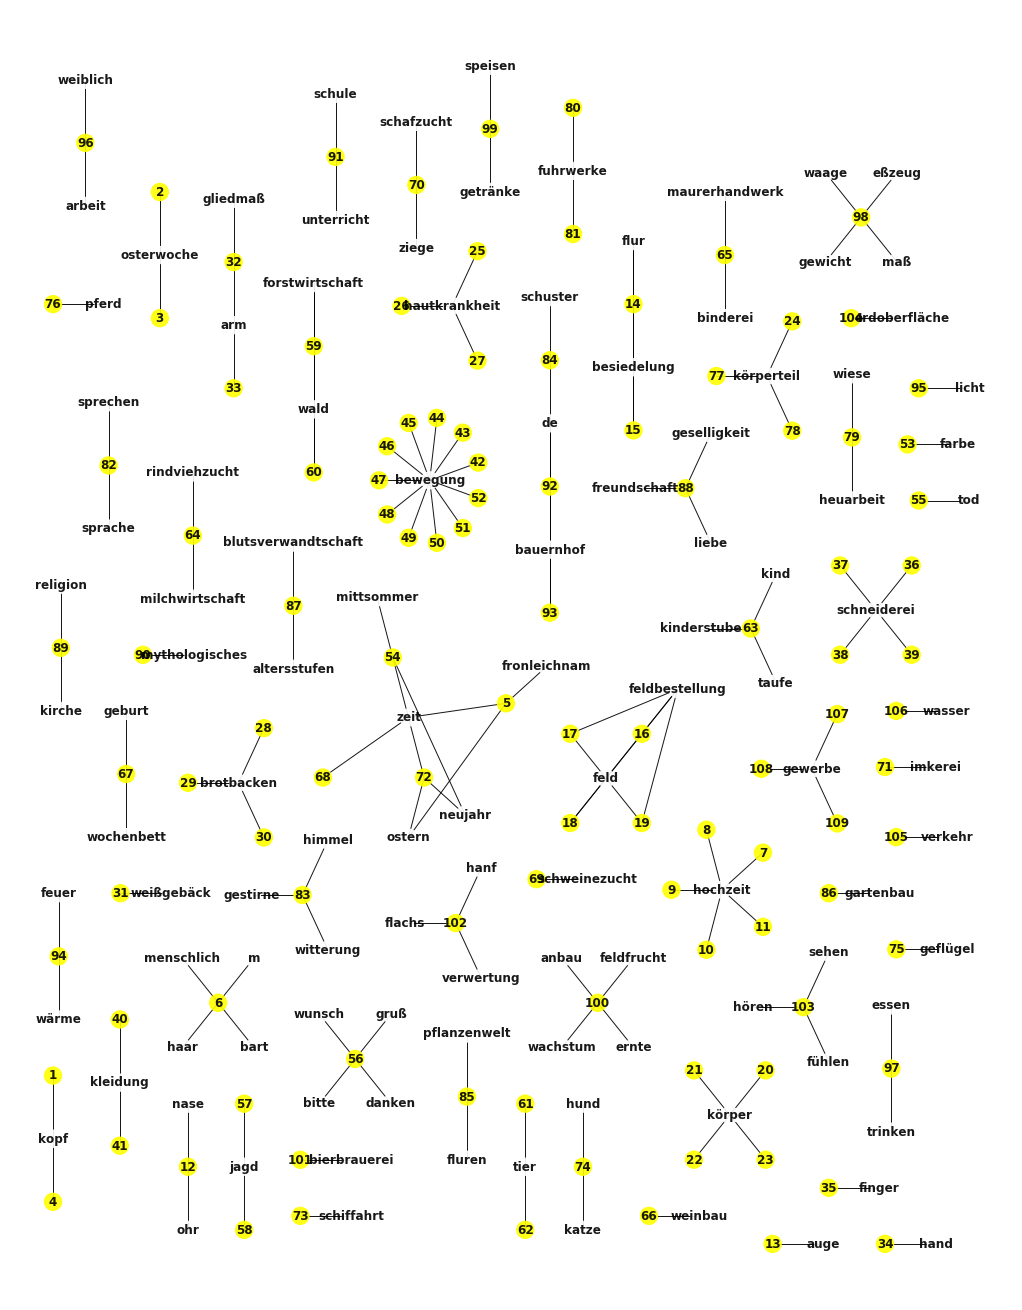

In [41]:
#https://stackoverflow.com/questions/48240021/alter-edge-length-and-cluster-spacing-in-networkx-matplotlib-force-graph
#if Win: https://graphviz.gitlab.io/_pages/Download/Download_windows.html
# https://stackoverflow.com/questions/4571067/installing-pygraphviz-on-windows?rq=1
#if Anaconda: conda install graphviz pygraphviz -c alubbock
#pip install --global-option=build_ext --global-option="-IC:\Program Files\<path>\Graphviz2.38\include" --global-option="-LC:\Program Files\Graphviz2.38\lib\release\lib" pygraphviz

plt.figure(figsize=(14,18))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw(G, 
        pos,
        #width=5,
        alpha=0.9,
        #cmap=plt.get_cmap('viridis'),
        node_color=nx.get_node_attributes(G,'color').values(), 
        with_labels=True,
        font_weight='bold', 
        #font_color='white',
       )


plt.show()

## 2 - Frage

#### Reading frage information

In [42]:
frage = pd.read_csv('./csv/frage.csv', names=["id", "fragebogen_id","nummer", "original_frage", "kurzfrage", "originaldaten"])

In [43]:
frage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24382 entries, 0 to 24381
Data columns (total 6 columns):
id                24382 non-null int64
fragebogen_id     24382 non-null int64
nummer            24382 non-null object
original_frage    24382 non-null object
kurzfrage         17413 non-null object
originaldaten     6528 non-null object
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


#### Filtering the relevant columns and the original questionnaires

In [44]:
frage.drop(["id", "originaldaten", "kurzfrage"], axis=1, inplace=True)
frage = frage[frage.fragebogen_id <= 109]
frage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16744 entries, 0 to 16743
Data columns (total 3 columns):
fragebogen_id     16744 non-null int64
nummer            16744 non-null object
original_frage    16744 non-null object
dtypes: int64(1), object(2)
memory usage: 523.2+ KB


In [45]:
frage.head()

fragebogen_id nummer                                     original_frage
0              1     A1           Kopf: Kopf, Haupt; auch scherzh./übertr.
1              1     A2  Kopf: Kopf/Haupt (in urspr. Bed.) in Vergl./Ra...
2              1     A3  Kopf: Kopf/Haupt (übertr.) in Vergl./Ra. (das ...
3              1     A4  Kopf: schöner, ebenmäßig gebauter Kopf (Christ...
4              1    A4a                Kopf: häßlicher, unebenmäßiger Kopf

In [46]:
frage.tail()

fragebogen_id nummer                                     original_frage
16739            109    602                          Gewerbe: (Gehalts-)Zulage
16740            109    603                      Gewerbe: Abzug v. Gehalt, Pl.
16741            109    604  Gewerbe: sonstige heute noch lebende, bodenstä...
16742            109    605  Gewerbe: abgekommene, bodenständige Berufe, di...
16743            109    606  Gewerbe: bodenständige FN, die vermutl. auf ei...

#### Extracting information from the frage "original_frage" field

In [47]:
regex2 = r'([A-ZÄÖÜa-zäöüß.\(\)\-\/]+)[:]{1}([A-ZÄÖÜa-zäöüß0-9=,;:\-\(\)\.\?\s]+)'

frage.original_frage.str.extract(regex2).head(10)

0                                                  1
0  Kopf                         Kopf, Haupt; auch scherzh.
1  Kopf                                               Kopf
2  Kopf                                               Kopf
3  Kopf   schöner, ebenmäßig gebauter Kopf (Christuskop...
4  Kopf                      häßlicher, unebenmäßiger Kopf
5  Kopf                            großer Kopf; großkopfig
6  Kopf                                         Wasserkopf
7  Kopf                                       kleiner Kopf
8  Kopf                             oben zugespitzter Kopf
9  Kopf                                        langer Kopf

In [48]:
frage['main_theme'] = frage.original_frage.str.extract(regex2)[0]
frage[frage['main_theme'].isna()]
#frage['main_theme'].value_counts()

fragebogen_id nummer                                     original_frage  \
3605             41      E                            siehe 67E (Ergänzungen)   
3606             41      F                            siehe 67F (Ergänzungen)   
3607             41      E                   im Fragebuch Ergänzung unter 67E   
3608             41      F                   im Fragebuch Ergänzung unter 67F   
9125             69      C  Körperteile des Schweines, soweit von Rind/Wil...   
9135             69      D                     Lebensäußerungen des Schweines   

     main_theme  
3605        NaN  
3606        NaN  
3607        NaN  
3608        NaN  
9125        NaN  
9135        NaN

In [49]:
frage['main_theme'] = frage.original_frage.str.extract(regex2)[0]
frage.dropna(subset=['main_theme'], inplace=True,)
frage['question_words'] = frage.original_frage.str.extract(regex2)[1].str.strip()

#### Expanding abbreviations, tokenizing, eliminating stopwords and lemmatizing¶

In [50]:
changes = {}

frage['main_theme'] = frage['main_theme'].apply(expand_tokenize_clean_lemmatize)

/usr/local/lib/python3.6/dist-packages/pattern/text/__init__.py:2127: DeprecationWarning: generator '_read' raised StopIteration
  for v in _read(self._path):


In [51]:
for key, value in sorted(changes.items()):
    print(key, "----> ", value)

abbreviation: Almwirtsch. ---->   Almwirtschaft 
abbreviation: Aufbahrg. ---->   Aufbahrung 
abbreviation: Bewegg. ---->   Bewegung 
abbreviation: Bodenerhebg. ---->   Bodenerhebung 
abbreviation: Bw. ---->   Bestimmungswort 
abbreviation: Eigensch. ---->   Eigenschaften 
abbreviation: Gw. ---->   Grundwort 
abbreviation: Nov. ---->   November 
abbreviation: Okt. ---->   Oktober 
abbreviation: a. ---->   am 
abbreviation: achtg. ---->   ACHTUNG 
abbreviation: adv. ---->   Adverbien 
abbreviation: amtl. ---->   amtlich 
abbreviation: autkrankh. ---->   Hautkrankheit 
abbreviation: bearbeitg. ---->   Bearbeitung 
abbreviation: bereitg. ---->   Bereitung 
abbreviation: bes. ---->   besondere 
abbreviation: best. ---->   bestimmte 
abbreviation: bewegg. ---->   Bewegung 
abbreviation: d. ---->   der 
abbreviation: einrichtg. ---->   Einrichtung 
abbreviation: entzündg. ---->   Entzündung 
abbreviation: ept. ---->   September 
abbreviation: erg. ---->   ergänze 
abbreviation: erkrankg. ----

In [52]:
changes = {}
frage['question_words'] = frage.question_words.apply(expand_tokenize_clean_lemmatize)

In [53]:
for key, value in sorted(changes.items()):
    print(key, "----> ", value)

abbreviation: .Bed. ---->   Bedeutung 
abbreviation: .Füg. ---->   Fügungen 
abbreviation: .Komp. ---->   Komposita 
abbreviation: .Untersch. ---->   Unterschied 
abbreviation: .Vb. ---->   Verba 
abbreviation: .Volksüberlieferg. ---->   Volksüberlieferung 
abbreviation: .d. ---->   der 
abbreviation: .dgl. ---->   dergleichen 
abbreviation: .zw. ---->   zwischen 
abbreviation: .ähnl. ---->   ähnlich 
abbreviation: A. ---->   Auge 
abbreviation: ASg. ---->   Akkusativ Singular 
abbreviation: Abb. ---->   Abbildung 
abbreviation: Abl. ---->   Ableitungen 
abbreviation: Ableitg. ---->   Ableitung  
abbreviation: Abrechng. ---->   Abrechnung 
abbreviation: Abschuppg. ---->   Abschuppung 
abbreviation: Abschwächg. ---->   Abschwächung 
abbreviation: Abteilg. ---->   Abteilung 
abbreviation: Abweisg. ---->   Abweisung 
abbreviation: Abzahlg. ---->   Abzahlung 
abbreviation: Ackerbez. ---->   Ackerbezeichnungen 
abbreviation: Ackerg. ---->   Ackerung 
abbreviation: Adj. ---->   Adjektiv 
abb

In [54]:
concepts = []
for i in frage.index:
    a = frage.loc[i,'main_theme']
    b = frage.loc[i, 'question_words']
    concepts.append(list(set(a+b)))

frage['question_words'] = concepts

frage.head(20)
#frage.info()

fragebogen_id nummer                                     original_frage  \
0               1     A1           Kopf: Kopf, Haupt; auch scherzh./übertr.   
1               1     A2  Kopf: Kopf/Haupt (in urspr. Bed.) in Vergl./Ra...   
2               1     A3  Kopf: Kopf/Haupt (übertr.) in Vergl./Ra. (das ...   
3               1     A4  Kopf: schöner, ebenmäßig gebauter Kopf (Christ...   
4               1    A4a                Kopf: häßlicher, unebenmäßiger Kopf   
5               1     A5                      Kopf: großer Kopf; großkopfig   
6               1    A5a                                   Kopf: Wasserkopf   
7               1     A6                                 Kopf: kleiner Kopf   
8               1     A7                       Kopf: oben zugespitzter Kopf   
9               1     A8                                  Kopf: langer Kopf   
10              1     A9                         Kopf: kurzer, platter Kopf   
11              1    A10                                  Kopf: runder Kopf   
12              1    A11                                 Kopf: breiter Kopf   
13              1    A12                                Kopf: schmaler Kopf   
14              1    A13                                Kopf: schiefer Kopf   
15              1    A14  Kopf: Kopf mit dunkler Gesichtsfarbe und kraus...   
16              1    A15  Kopf: mißgestalteter Kopf (Fischkopf "Kindskop...   
17              1    A16  Kopf: Kopf mit Ungeziefer behaftet (Laus-, Niß...   
18              1    A17    Kopf: Krankheiten des Kopfes (Kopfweh, -typhus)   
19              1   A17a  Kopf: durch Krankheiten entstellter Kopf (Krät...   

   main_theme                                     question_words  
0      [kopf]                          [scherzhaft, kopf, haupt]  
1      [kopf]                                             [kopf]  
2      [kopf]                                             [kopf]  
3      [kopf]  [ebenmäßig, gebaut, kopf, tituskopf, christusk...  
4      [kopf]                       [kopf, unebenmäßig, häßlich]  
5      [kopf]                           [kopf, großkopfig, groß]  
6      [kopf]                                 [kopf, wasserkopf]  
7      [kopf]                                      [kopf, klein]  
8      [kopf]                           [kopf, oben, zugespitzt]  
9      [kopf]                                       [lang, kopf]  
10     [kopf]                                [kopf, platt, kurz]  
11     [kopf]                                       [kopf, rund]  
12     [kopf]                                      [kopf, breit]  
13     [kopf]                                     [schmal, kopf]  
14     [kopf]                                     [kopf, schief]  
15     [kopf]  [kopf, dunkel, kraus, mohrenkopf, gesichtsfarb...  
16     [kopf]                  [fischkopf, kopf, mißgestalteter]  
17     [kopf]       [behafteen, laus, kopf, nißkopf, ungeziefer]  
18     [kopf]     [krankheit, typhus, kopf, de, kopfweh, kopfes]  
19     [kopf]   [krankheit, kopf, grindkopf, entstellt, krätzen]

#### Examining the common concepts

In [55]:
concepts = []
for entry in frage.question_words.values:  
    for concept in entry:
        concepts.append(concept)
concepts = [c for c in concepts if c not in german_stopwords]
concepts = collections.Counter(concepts)
concepts.most_common(40)

[('de', 3504),
 ('amen', 1646),
 ('komposita', 1534),
 ('r', 1107),
 ('bein', 739),
 ('laufen', 739),
 ('bauer', 725),
 ('beispiel', 676),
 ('bedeutung', 675),
 ('p', 609),
 ('gewerbe', 609),
 ('gentiana', 583),
 ('körper', 477),
 ('hand', 473),
 ('hose', 405),
 ('besonderer', 372),
 ('handschuh', 371),
 ('au', 369),
 ('ausdrücke', 359),
 ('feld', 344),
 ('wild', 337),
 ('v', 309),
 ('ableitungen', 309),
 ('bewegung', 264),
 ('kopf', 260),
 ('jagd', 260),
 ('bezeichnung', 257),
 ('waldbaum', 256),
 ('u', 242),
 ('deminutiv', 237),
 ('gehen', 236),
 ('erst', 222),
 ('name', 212),
 ('schneiderei', 212),
 ('o', 202),
 ('h', 196),
 ('ü', 193),
 ('teil', 190),
 ('kommen', 189),
 ('üblich', 181)]

#### Drawing the Graphs of specific Fragebogen / Frage concepts

In [56]:
filtered = frage[frage.fragebogen_id <= 4]

In [57]:
G = nx.Graph()

for concept_list in filtered.question_words:
    for concept in concept_list:
        G.add_node(concept, color='white')
        
for questionnaire in filtered.fragebogen_id:
    G.add_node(questionnaire, color='yellow')
    
for idn in filtered.index:
    for concept in filtered.loc[idn, 'question_words']:
        G.add_edge(concept, filtered.loc[idn, 'fragebogen_id'], length = 10)

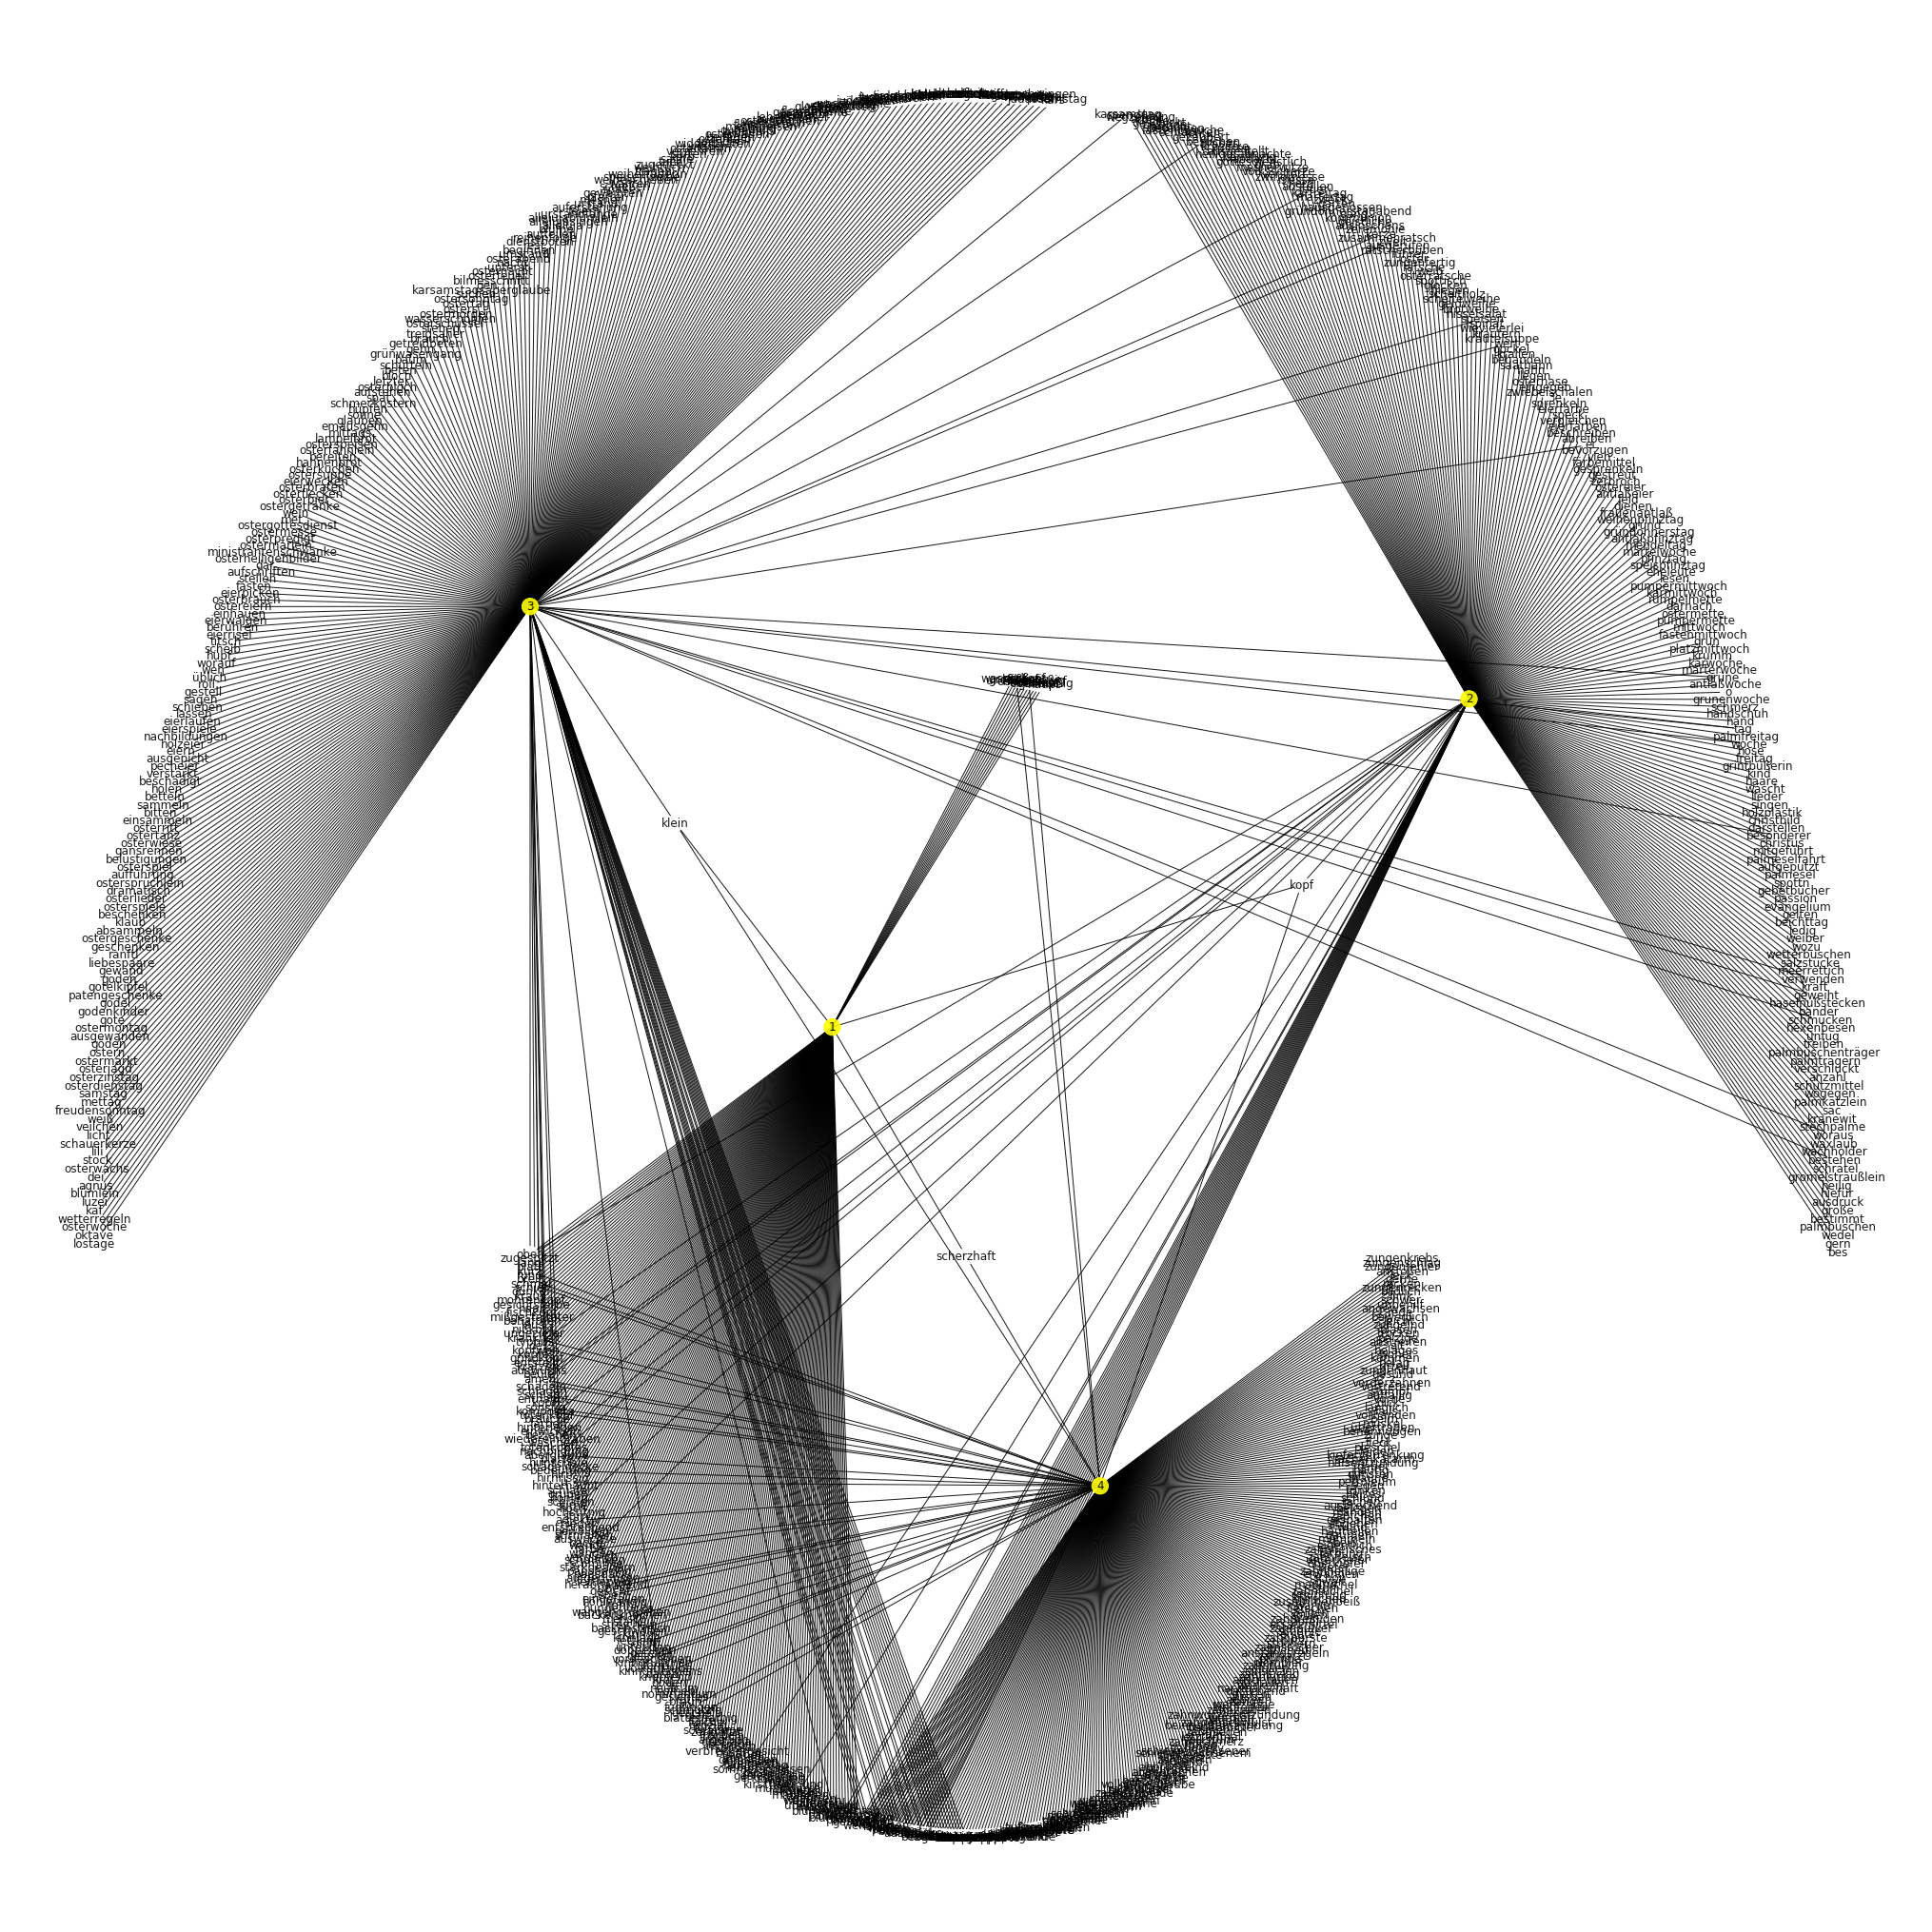

In [58]:
plt.figure(figsize=(28,28))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw(G, 
        pos,
        #width=5,
        alpha=0.9,
        #cmap=plt.get_cmap('viridis'),
        node_color=nx.get_node_attributes(G,'color').values(), 
        with_labels=True,
        #font_weight='bold', 
        #font_color='white',
       )


plt.show()

### Topic Modeling with the concepts

Preparing Document-Term Matrix

All the text documents combined is known as the corpus. To run any mathematical model on text corpus, it is a good practice to convert it into a matrix representation. LDA model looks for repeating term patterns in the entire DT matrix. Python provides many great libraries for text mining practices, “gensim” is one such clean and beautiful library to handle text data. It is scalable, robust and efficient. Following code shows how to convert a corpus into a document-term matrix.

In [59]:
all_concepts = []
for entry in frage.question_words.values:
    all_concepts.append(entry)
    
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(all_concepts)
dictionary.filter_extremes(no_below=1, no_above=0.8)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in all_concepts]

Running LDA Model

Next step is to create an object for LDA model and train it on Document-Term matrix. The training also requires few parameters as input which are explained in the above section. The gensim module allows both LDA model estimation from a training corpus and inference of topic distribution on new, unseen documents.

In [60]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=8, id2word = dictionary, passes=50)

In [61]:
ldamodel.print_topics(num_topics=8, num_words=5)
#ldamodel.show_topics(10)

[(0,
  '0.024*"mühle" + 0.022*"de" + 0.022*"bedeutung" + 0.021*"komposita" + 0.011*"jagd"'),
 (1,
  '0.020*"de" + 0.012*"post" + 0.011*"reden" + 0.009*"flachs" + 0.008*"wein"'),
 (2,
  '0.015*"wetter" + 0.014*"gerät" + 0.013*"schauen" + 0.012*"vogel" + 0.012*"gehen"'),
 (3,
  '0.127*"gewerbe" + 0.038*"de" + 0.012*"komposita" + 0.010*"bier" + 0.008*"korb"'),
 (4,
  '0.045*"komposita" + 0.031*"bein" + 0.029*"bauer" + 0.027*"beispiel" + 0.013*"de"'),
 (5, '0.073*"amen" + 0.057*"r" + 0.038*"laufen" + 0.033*"p" + 0.033*"de"'),
 (6,
  '0.058*"de" + 0.017*"besonderer" + 0.013*"bereitung" + 0.012*"eisenbahn" + 0.010*"ausdrücke"'),
 (7,
  '0.033*"hand" + 0.027*"hose" + 0.026*"handschuh" + 0.023*"v" + 0.018*"de"')]

In [62]:
topics_matrix = ldamodel.show_topics(formatted=False, num_words=20)
dic_topics = {num:words for num, words in topics_matrix}
df = pd.DataFrame(dic_topics)
df = df.reindex(sorted(df.columns), axis=1)
df.head(20)
#{num:words for num, words in topics_matrix}

0                                1  \
0         (mühle, 0.024276353)                (de, 0.020039119)   
1            (de, 0.022089377)             (post, 0.0115842605)   
2     (bedeutung, 0.021851785)             (reden, 0.010872996)   
3     (komposita, 0.021161076)            (flachs, 0.008625973)   
4           (jagd, 0.01107299)               (wein, 0.00840481)   
5      (gewässer, 0.010575394)       (volksglaube, 0.008330816)   
6    (ableitungen, 0.01050572)     (hautkrankheit, 0.007810351)   
7             (ü, 0.008397811)                 (h, 0.007715295)   
8       (üblich, 0.0076340633)       (hanfarbeit, 0.0072223954)   
9         (wiese, 0.006110024)            (führen, 0.006746812)   
10        (stelle, 0.00567267)                (o, 0.0051940302)   
11       (bauch, 0.0055155293)       (schlafraum, 0.0050314763)   
12     (beugung, 0.0054368456)  (rindfleischsorte, 0.004486482)   
13        (brot, 0.0052784644)               (oben, 0.00417937)   
14          (ab, 0.0052199853)       (weinkeller, 0.0037597471)   
15          (au, 0.0051891617)      (rinderleben, 0.0036921978)   
16     (heuernte, 0.005139118)          (kutsche, 0.0036063236)   
17         (heu, 0.0050268197)          (weinbau, 0.0035212561)   
18     (adjektiv, 0.004739918)             (käse, 0.0034141506)   
19  (übertragen, 0.0047221556)         (rübenbau, 0.0033666436)   

                               2                            3  \
0          (wetter, 0.014812182)        (gewerbe, 0.12672438)   
1           (gerät, 0.013937091)            (de, 0.037521783)   
2         (schauen, 0.012668898)     (komposita, 0.012278777)   
3           (vogel, 0.011889501)           (bier, 0.00969486)   
4            (gehen, 0.01155489)           (korb, 0.00787857)   
5      (schiffahrt, 0.008886854)         (teil, 0.0077933334)   
6         (schiff, 0.0069942065)         (tätig, 0.005826159)   
7           (hoch, 0.0069919648)   (nominandum, 0.0057834825)   
8          (insekt, 0.006775137)        (nomen, 0.0057834825)   
9              (au, 0.006422683)      (neutrum, 0.0057834825)   
10         (versc, 0.0052305907)  (mehlspeisen, 0.0057796505)   
11    (küchengerät, 0.005026137)            (sy, 0.005101789)   
12           (uhr, 0.0048750276)    (aussprache, 0.004765494)   
13  (wiesenpflanze, 0.004803013)       (schule, 0.0040666545)   
14      (hausputz, 0.0042736065)     (wohnhaus, 0.0037474516)   
15          (mehl, 0.0041739666)  (schiffsteil, 0.0035993343)   
16              (n, 0.004149026)       (fahren, 0.0035102004)   
17        (schwarz, 0.003751363)  (gartenblume, 0.0034903674)   
18     (ersetzung, 0.0037018622)     (ausdruck, 0.0031029629)   
19            (üb, 0.0037018622)           (tag, 0.003100574)   

                              4                             5  \
0      (komposita, 0.044595663)            (amen, 0.07300337)   
1           (bein, 0.030724086)              (r, 0.056642793)   
2          (bauer, 0.029452901)           (laufen, 0.0381452)   
3        (beispiel, 0.02732358)              (p, 0.033295773)   
4              (de, 0.01328491)             (de, 0.032504983)   
5      (deminutiv, 0.013276672)         (körper, 0.011007035)   
6       (bewegung, 0.011044345)          (wild, 0.0101891775)   
7           (baum, 0.007385265)      (komposita, 0.007964948)   
8   (schneiderei, 0.0073801284)          (kopf, 0.0059083984)   
9            (licht, 0.0066778)           (erst, 0.005898198)   
10         (fisch, 0.005711502)       (bräuche, 0.0053863283)   
11      (gasthaus, 0.004788665)         (brücke, 0.005015403)   
12         (stock, 0.004500859)        (kommen, 0.0049849385)   
13       (schwein, 0.004080436)            (au, 0.0045442013)   
14        (wasser, 0.003972136)         (gehen, 0.0043937494)   
15      (sonstig, 0.0039564306)  (zunftheiliger, 0.004123473)   
16            (u, 0.0039192303)       (zunfttag, 0.004123473)   
17    (bedeutung, 0.0037651546)           (fuß, 0.0039701723)   
18          (rot, 0.

In [63]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
pyLDAvis.save_html(p, 'lda.html')

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Using [Word Embeddings](https://devmount.github.io/GermanWordEmbeddings/#download)